## Setup

In [1]:
import json
import click
from pathlib import Path
from shutil import make_archive
import os
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
from numpy.random import default_rng
from typing import Tuple, Optional, Dict, Any
import jax.numpy as jnp
import jax.scipy.linalg as jsla
import operator
from sklearn.preprocessing import StandardScaler

from src.experiment import experiments, get_run_func

from src.utils import grid_search_dict
from src.utils.kernel_func import ColumnWiseGaussianKernel, AbsKernel, BinaryKernel, GaussianKernel
from src.utils.jax_utils import Hadamard_prod, mat_mul, mat_trans, modif_kron, cal_loocv_emb, cal_loocv_alpha, \
    stage2_weights

from src.data.ate import generate_train_data_ate, generate_test_data_ate, get_preprocessor_ate
from src.data.ate.data_class import PVTrainDataSet, PVTestDataSet

from src.models.PMMR.model import PMMRModel
from src.models.kernelPV.model import get_kernel_func, KernelPVModel
from src.models.NMMR.NMMR_trainers import NMMR_Trainer_DemandExperiment, NMMR_Trainer_dSpriteExperiment, \
    NMMR_Trainer_RHCExperiment

from src.data.ate import generate_train_data_ate, generate_val_data_ate, generate_test_data_ate, get_preprocessor_ate
from src.data.ate.data_class import PVTrainDataSet, PVTestDataSet, split_train_data, PVTrainDataSetTorch, \
    PVTestDataSetTorch, RHCTestDataSetTorch
from src.data.ate.exponential_pv import generatate_exponential_core

C:\Users\Benedikt\anaconda3new\envs\kompa\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Config

In [2]:
experiment_name = "exponential"
n_sample = 5000
beta_0 = 1
beta_a = 1
delta = 1
gamma = 1
lam_z = 1
lam_u = 1
U_noise = np.sqrt(0.1)
A_noise = np.sqrt(0.1)
W_noise = np.sqrt(0.1)
Z_noise = np.sqrt(0.1)
a_start = -2
a_end = 2

data_dic = {
      "name" : experiment_name,
      "n_sample" : n_sample,
      "beta_0": beta_0,
      "beta_a": beta_a,
      "delta": delta,
      "gamma": gamma,
      "lam_z": lam_z, 
      "lam_u": lam_u, 
      "U_noise": U_noise,
      "A_noise": A_noise,
      "Z_noise": Z_noise,
      "W_noise": W_noise,
      "a_start": a_start,
      "a_end": a_end,
}


pmmr_configs = {
    "n_repeat": 1,
    "data": data_dic,
    "model": {
        "name": "pmmr",
        "lam1": 0.01,
        "lam2": 0.01,
        "scale": 0.5,
        "data_scaling": True
    }
}


kpv_configs = {
    "n_repeat": 1,
    "data": data_dic,
    "model": {
        "name": "kpv",
        "lam1": 0.001,
        "lam2": 0.001,
        "split_ratio": 0.5,
        "scale": 0.5,
        "data_scaling": True,
    }
}

nmmr_u_configs = {
  "n_repeat": 1,
  "data": data_dic,
  "model": {
    "name": "nmmr",
    "n_epochs": 3000,
    "batch_size": 1000,
    "log_metrics": "False",
    "learning_rate": 0.003,
    "l2_penalty": 3e-06,
    "loss_name": "U_statistic",
    "network_depth": 4,
    "network_width": 80
  }
}

nmmr_v_configs = {
  "n_repeat": 1,
  "data": data_dic,
  "model": {
    "name": "nmmr",
    "n_epochs": 3000,
    "batch_size": 1000,
    "log_metrics": "False",
    "learning_rate": 0.003,
    "l2_penalty": 3e-06,
    "loss_name": "V_statistic",
    "network_depth": 3,
    "network_width": 80
  }
}

verbose = 2

## Functions

In [3]:
def pmmr_exp(data_config: Dict[str, Any], model_param: Dict[str, Any],
                     random_seed: int = 42, verbose: int = 0):
    train_data_org = generate_train_data_ate(data_config=data_config, rand_seed=random_seed)
    val_data_org = generate_train_data_ate(data_config=data_config, rand_seed=random_seed+1)
    test_data_org = generate_test_data_ate(data_config=data_config)

    preprocessor = get_preprocessor_ate(data_config.get("preprocess", "Identity"))
    train_data = preprocessor.preprocess_for_train(train_data_org)
    val_data = preprocessor.preprocess_for_train(val_data_org)
    test_data = preprocessor.preprocess_for_test_input(test_data_org)

    model = PMMRModel(**model_param)
    model.fit(train_data, data_config["name"])
    
    # predict true effect
    pred = model.predict(test_data.treatment)
    pred = preprocessor.postprocess_for_prediction(pred)
    
    # predict h(a, w) (bridge fct) on val_set for A and W
    pred_bridge = model.predict_bridge(val_data.treatment, val_data.outcome_proxy)
    pred_bridge = preprocessor.postprocess_for_prediction(pred_bridge)
    
    mse = np.mean((pred - test_data.structural) ** 2)
    mae = np.mean(np.abs(pred - test_data.structural))
    
    return train_data, test_data, val_data, pred, mse, mae, pred_bridge

In [4]:
def kpv_exp(data_config: Dict[str, Any], model_param: Dict[str, Any],
                    random_seed: int = 42, verbose: int = 0):
    train_data_org = generate_train_data_ate(data_config=data_config, rand_seed=random_seed)
    test_data_org = generate_test_data_ate(data_config=data_config)

    preprocessor = get_preprocessor_ate(data_config.get("preprocess", "Identity"))
    train_data = preprocessor.preprocess_for_train(train_data_org)
    test_data = preprocessor.preprocess_for_test_input(test_data_org)

    model = KernelPVModel(**model_param)
    model.fit(train_data, data_config["name"])
    
    pred = model.predict(test_data.treatment)
    pred = preprocessor.postprocess_for_prediction(pred)
    
    mse = np.mean((pred - test_data.structural) ** 2)
    mae = np.mean(np.abs(pred - test_data.structural))
    
    return train_data, test_data, pred, mse, mae

In [5]:
def NMMR_exp(data_config: Dict[str, Any], model_config: Dict[str, Any],
                    one_mdl_dump_dir: Path,
                    random_seed: int = 42, verbose: int = 0):
    # set random seeds
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)

    # generate train data
    train_data = generate_train_data_ate(data_config=data_config, rand_seed=random_seed)
    val_data = generate_val_data_ate(data_config=data_config, rand_seed=random_seed + 1)
    test_data = generate_test_data_ate(data_config=data_config)

    # convert datasets to Torch (for GPU runtime)
    train_t = PVTrainDataSetTorch.from_numpy(train_data)
    val_data_t = PVTrainDataSetTorch.from_numpy(val_data)

    data_name = data_config.get("name", None)
    if data_name in ['dsprite', 'demand', 'exponential']:
        test_data_t = PVTestDataSetTorch.from_numpy(test_data)
    elif data_name == 'rhc':
        test_data_t = RHCTestDataSetTorch.from_numpy(test_data)
    else:
        raise KeyError(f"Your data config contained name = {data_name}, but must be one of [dsprite, demand, rhc, exponential]")

    # retrieve the trainer for this experiment
    if data_name == "dsprite":
        trainer = NMMR_Trainer_dSpriteExperiment(data_config, model_config, random_seed, one_mdl_dump_dir)
    elif data_name in ['exponential', 'demand']:
        trainer = NMMR_Trainer_DemandExperiment(data_config, model_config, random_seed, one_mdl_dump_dir)
    elif data_name == 'rhc':
        trainer = NMMR_Trainer_RHCExperiment(data_config, model_config, random_seed, one_mdl_dump_dir)

    # train model
    model = trainer.train(train_t, val_data_t, verbose)

    # prepare test data on the gpu
    if trainer.gpu_flg:
        # torch.cuda.empty_cache()
        test_data_t = test_data_t.to_gpu()
        val_data_t = val_data_t.to_gpu()

    if data_name == "dsprite":
        E_wx_hawx = trainer.predict(model, test_data_t, val_data_t, batch_size=model_config.get('val_batch_size', None))
    elif data_name in ['exponential', 'demand']:
        E_wx_hawx = trainer.predict(model, test_data_t, val_data_t)
    elif data_name == "rhc":
        E_wx_hawx = trainer.predict(model, test_data_t)

    pred = E_wx_hawx.detach().numpy()
    np.savetxt(one_mdl_dump_dir.joinpath(f"{random_seed}.pred.txt"), pred)

    if hasattr(test_data, 'structural'):
        # test_data.structural is equivalent to EY_doA
        np.testing.assert_array_equal(pred.shape, test_data.structural.shape)
        oos_loss = np.mean((pred - test_data.structural) ** 2)
        
        mse = np.mean((pred - test_data.structural) ** 2)
        mae = np.mean(np.abs(pred - test_data.structural))
    else:
        oos_loss = None

        mse = None
        mae = None
    
    return train_data, test_data, pred, mse, mae

## Evaluations

In [6]:
%%time
data_config_pmmr = pmmr_configs["data"]
model_config_pmmr = pmmr_configs["model"]

train_data_pmmr, test_data_pmmr, val_data_pmmr, pred_pmmr, mse_pmmr, mae_pmmr, pred_bridge_pmmr = pmmr_exp(data_config=data_config_pmmr, model_param=model_config_pmmr, random_seed = 42, verbose=verbose)
# CPU times: total: 1.55 s
# Wall time: 412 ms

CPU times: total: 1min 37s
Wall time: 22.2 s


In [7]:
%%time
data_config_kpv = kpv_configs["data"]
model_config_kpv = kpv_configs["model"]

train_data_kpv, test_data_kpv, pred_kpv, mse_kpv, mae_kpv = kpv_exp(data_config=data_config_kpv, model_param=model_config_kpv, random_seed = 42, verbose=verbose)
# CPU times: total: 20.4 s
# Wall time: 18.7 s

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


CPU times: total: 3min 4s
Wall time: 2min 21s


In [8]:
%%time
DUMP_DIR = Path.cwd().joinpath('dumps')
data_config_nmmr_u = nmmr_u_configs["data"]
model_config_nmmr_u = nmmr_u_configs["model"]


train_data_nmmr_u, test_data_nmmr_u, pred_nmmr_u, mse_nmmr_u, mae_nmmr_u = NMMR_exp(data_config=data_config_nmmr_u, model_config=model_config_nmmr_u, one_mdl_dump_dir = DUMP_DIR, random_seed=42, verbose = verbose)
# CPU times: total: 7min 19s
# Wall time: 1min 56s

100%|██████████| 3000/3000 [09:43<00:00,  5.14it/s]

CPU times: total: 37min 26s
Wall time: 9min 44s


In [9]:
%%time
DUMP_DIR = Path.cwd().joinpath('dumps')
data_config_nmmr_v = nmmr_v_configs["data"]
model_config_nmmr_v = nmmr_v_configs["model"]


train_data_nmmr_v, test_data_nmmr_v, pred_nmmr_v, mse_nmmr_v, mae_nmmr_v = NMMR_exp(data_config=data_config_nmmr_v, model_config=model_config_nmmr_v, one_mdl_dump_dir = DUMP_DIR, random_seed=42, verbose = verbose)
# CPU times: total: 7min 42s
# Wall time: 1min 59s

100%|██████████| 3000/3000 [09:33<00:00,  5.23it/s]


CPU times: total: 36min 57s
Wall time: 9min 34s


## Theoretitcal Considerations for h(a, w) and h(a)

In [10]:
def calc_haw(A, W, e_w, beta_0, beta_a, delta):
    
    delta_star = 1/delta
    delta_tilde = np.mean(np.exp(delta_star*e_w))
    beta_0_bar = beta_0 - np.log(delta_tilde)
    
    haw = np.exp(beta_0_bar + beta_a * A + delta_star*W)
    ha = np.exp(beta_0_bar + beta_a * A) * np.mean(np.exp(delta_star*W))
    return haw, ha

def gen_haw(a, beta_0, beta_a, delta, U_noise, W_noise):
    rng = default_rng(seed=42)
    
    U = rng.normal(0, U_noise, 10000)
    e_w = rng.normal(0, W_noise, 10000)
    W = delta * U + e_w
    
    haw, ha = calc_haw(a, W, e_w, beta_0, beta_a, delta)
    
    return haw, ha

def ha_effect(a_start, a_end, beta_0, beta_a, delta, U_noise, W_noise):
    a_steps = np.linspace(a_start, a_end, 10)
    ha = np.array([gen_haw(a, beta_0, beta_a, delta, U_noise, W_noise)[1] for a in a_steps])
    return a_steps, ha

## Plots

### The theoretical bridge function h(a) is EXACTLY the true effect!

#### The estimated bridge function h(a) from PMMR is already the predicted curve

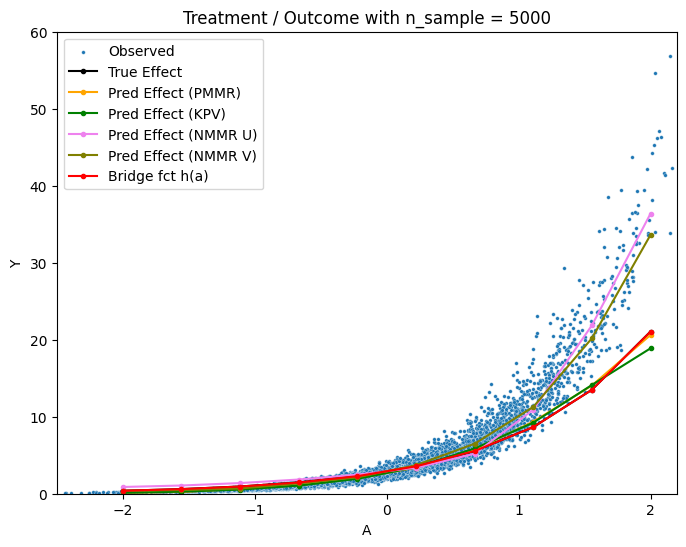

In [13]:
import importlib
importlib.reload(plt)

A_train = np.squeeze(train_data_pmmr.treatment)
W_train = np.squeeze(train_data_pmmr.outcome_proxy)
Y_train = np.squeeze(train_data_pmmr.outcome)
A_test = test_data_pmmr.treatment
Y_test = test_data_pmmr.structural
Y_pred_pmmr = pred_pmmr
Y_pred_kpv = pred_kpv
Y_pred_nmmr_u = pred_nmmr_u
Y_pred_nmmr_v = pred_nmmr_v
_, ha = ha_effect(a_start, a_end, beta_0, beta_a, delta, U_noise, W_noise)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=A_train, y=Y_train, label='Observed', s=7)
plt.plot(A_test, Y_test, color='black', marker='o', label="True Effect", markersize = 3)
plt.plot(A_test, Y_pred_pmmr, color='orange', marker='o', label="Pred Effect (PMMR)", markersize = 3)
plt.plot(A_test, Y_pred_kpv, color='green', marker='o', label="Pred Effect (KPV)", markersize = 3)
plt.plot(A_test, Y_pred_nmmr_u, color='violet', marker='o', label="Pred Effect (NMMR U)", markersize = 3)
plt.plot(A_test, Y_pred_nmmr_v, color='olive', marker='o', label="Pred Effect (NMMR V)", markersize = 3)
plt.plot(A_test, ha, color='red', marker='o', label="Bridge fct h(a)", markersize = 3)
plt.title(f'Treatment / Outcome with n_sample = {n_sample}')
plt.xlabel('A')
plt.xlim([-2.5, 2.2])
plt.ylabel('Y')
plt.ylim([0, 60])
plt.legend()
plt.show()

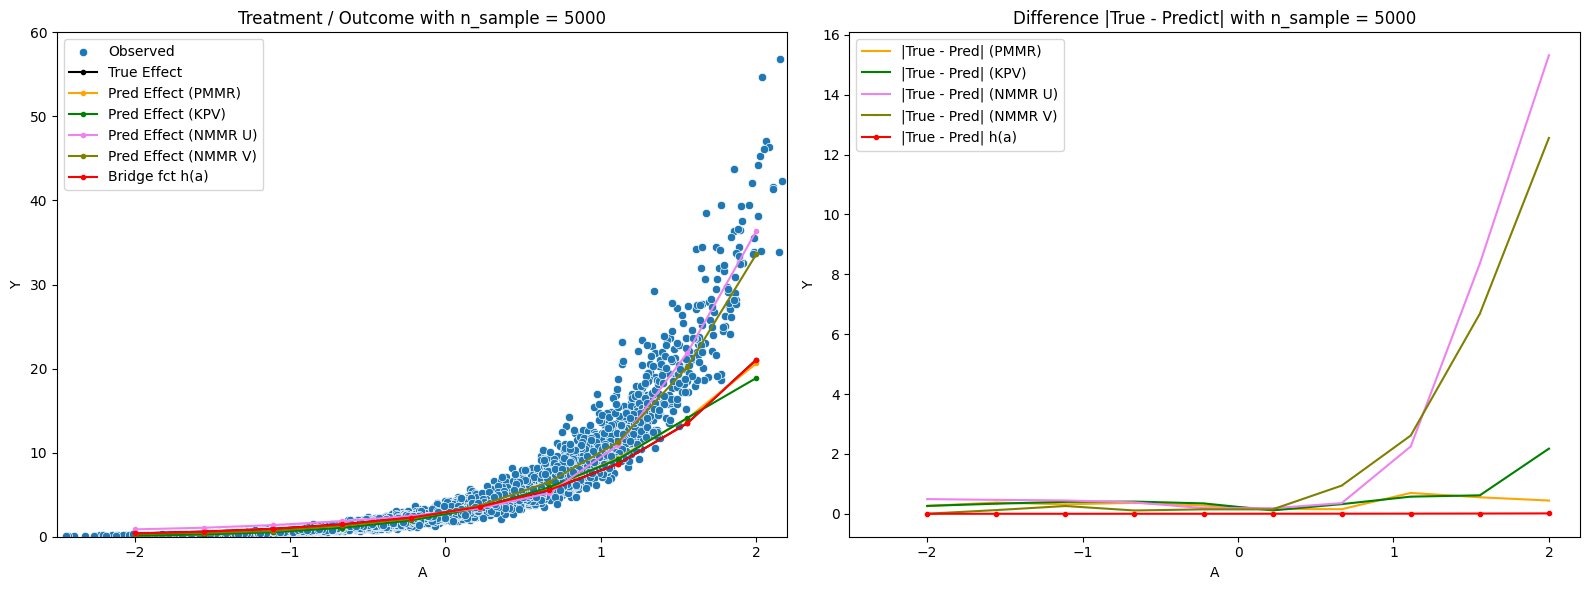

In [14]:
# Plot Results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(x=A_train, y=Y_train, label='Observed', ax=ax1)
ax1.plot(A_test, Y_test, color='black', marker='o', label="True Effect", markersize = 3)
ax1.plot(A_test, Y_pred_pmmr, color='orange', marker='o', label="Pred Effect (PMMR)", markersize = 3)
ax1.plot(A_test, Y_pred_kpv, color='green', marker='o', label="Pred Effect (KPV)", markersize = 3)
ax1.plot(A_test, Y_pred_nmmr_u, color='violet', marker='o', label="Pred Effect (NMMR U)", markersize = 3)
ax1.plot(A_test, Y_pred_nmmr_v, color='olive', marker='o', label="Pred Effect (NMMR V)", markersize = 3)
ax1.plot(A_test, ha, color='red', marker='o', label="Bridge fct h(a)", markersize = 3)
ax1.set_title(f'Treatment / Outcome with n_sample = {n_sample}')
ax1.set_xlabel('A')
ax1.set_xlim([-2.5, 2.2])
ax1.set_ylabel('Y')
ax1.set_ylim([0, 60])
ax1.legend()


ax2.plot(A_test, np.abs(Y_test - pred_pmmr), color='orange', marker='o', label="|True - Pred| (PMMR)", markersize=0.1)
ax2.plot(A_test, np.abs(Y_test - pred_kpv), color='green', marker='o', label="|True - Pred| (KPV)", markersize=0.1)
ax2.plot(A_test, np.abs(Y_test - pred_nmmr_u), color='violet', marker='o', label="|True - Pred| (NMMR U)", markersize=0.1)
ax2.plot(A_test, np.abs(Y_test - pred_nmmr_v), color='olive', marker='o', label="|True - Pred| (NMMR V)", markersize=0.1)
ax2.plot(A_test, np.abs(np.squeeze(Y_test) - ha), color='red', marker='o', label="|True - Pred| h(a)", markersize = 3)
ax2.set_title(f'Difference |True - Predict| with n_sample = {n_sample}')
ax2.set_xlabel('A')
ax2.set_xlim([-2.5, 2.2])
ax2.set_ylabel('Y')
ax2.legend()

plt.tight_layout()
plt.show()

#### Bridge Function h(a, w) in 3D

In [15]:
def gen_haw_full(n_sample, beta_0, beta_a, gamma, delta, lam_z, lam_u, U_noise, W_noise, A_noise, Z_noise):
    rng = default_rng(seed=42)
    
    U = rng.normal(0, U_noise, n_sample)
    e_w = rng.normal(0, W_noise, n_sample)
    e_z = rng.normal(0, Z_noise, n_sample)
    e_a = rng.normal(0, A_noise, n_sample)
    W = delta * U + e_w
    Z = gamma * U + e_z
    A = lam_z * Z + lam_u * U + e_a
    
    haw, ha = calc_haw(A, W, e_w, beta_0, beta_a, delta)
    
    return A, W, haw

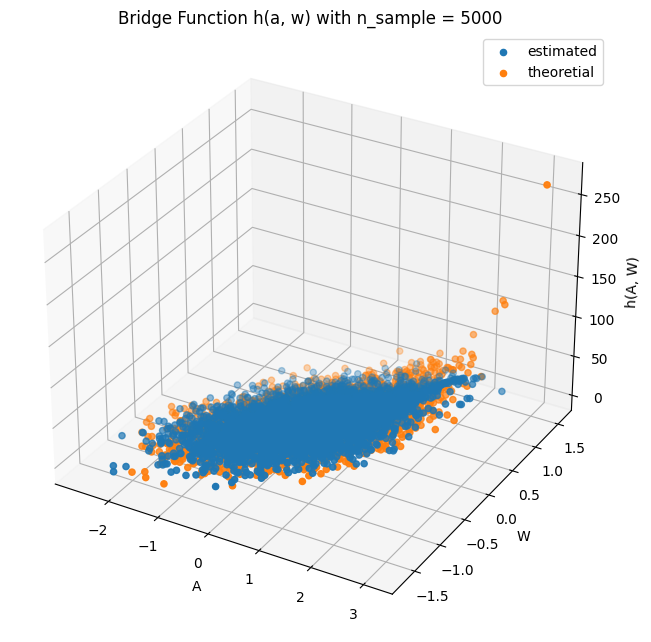

In [16]:
from mpl_toolkits.mplot3d import Axes3D

A_val = np.squeeze(val_data_pmmr.treatment)
W_val = np.squeeze(val_data_pmmr.outcome_proxy)
haw_pmmr = np.squeeze(pred_bridge_pmmr)

A_theory, W_theory, haw_theory = gen_haw_full(n_sample, beta_0, beta_a, gamma, delta, lam_z, lam_u, U_noise, W_noise, A_noise, Z_noise)


fig = plt.figure(figsize=(6,6))

ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

ax.scatter(A_val, W_val, haw_pmmr, marker='o', label="estimated")
ax.scatter(A_theory, W_theory, haw_theory, marker='o', label="theoretial")
ax.set_xlabel('A')
ax.set_ylabel('W')
ax.set_zlabel('h(A, W)')

ax.legend()
plt.title(f'Bridge Function h(a, w) with n_sample = {n_sample}')

plt.show()

## TODO